# Network Anomaly Detection

## Contributors

#### Amr Yasser 6772
#### Elhussein Sabri 6716
#### Marwan Khaled 7020


## References 
[https://www.ecb.torontomu.ca/~bagheri/papers/cisda.pdf](Detailed Analysis of the KDD CUP 99 Data Set Mahbod Tavallaee, Ebrahim Bagheri, Wei Lu, and Ali A. Ghorban)
https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html

## Download Datset 

You can Import data set from 
* [KDD CUP 1999 DATA](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)
or Download it from kaggle

### Imports

In [2]:
import os
# Import the necessary libraries
from PIL import Image
import numpy as np
import torch 
import pandas as pd
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


### Utils

In [3]:
# Define the K-Means algorithm
def kmeans(data, k):
    # Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    prev_centroids = np.zeros(centroids.shape)

    while not np.allclose(centroids, prev_centroids):
        prev_centroids = centroids.copy()

        # Assign each point to the closest centroid
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Update centroids
        for i in range(k):
            centroids[i] = np.mean(data[labels == i], axis=0)

    return labels

In [5]:
# Define the Normalized Cuts algorithm
def normalized_cuts(data, k):
    # Compute the affinity matrix
    distances = np.sqrt(((data[:, np.newaxis] - data)**2).sum(axis=2))
    sigma = np.median(distances)
    W = np.exp(-distances**2 / (2*sigma**2))

    # Compute the diagonal degree matrix
    D = np.diag(W.sum(axis=1))

    # Compute the Laplacian matrix
    L = D - W

    # Compute the eigenvectors of the Laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Select the k smallest eigenvectors and normalize them
    X = eigenvectors[:, :k]
    X_norm = X / np.sqrt((X**2).sum(axis=1))[:, np.newaxis]

    # Cluster the normalized eigenvectors using K-Means
    labels = kmeans(X_norm, k)

    return labels

In [6]:
def display_data(D,y,title):
  print(f'\n{title}:')
  print(f'Data shape: {D.shape}')
  df = pd.DataFrame(D)
  df['Id'] = y

  print('\nValue counts:')
  plt.figure(figsize=(12,8))

  sns.countplot(x=df['Id'])
  plt.show()


  sample = D[np.random.choice(D.shape[0], 
                                  size=6, 
                                  replace=False),:]

  print('\nSample from data:')
  plt.figure(figsize=(12,8))
  i=1
  for s in sample:
    plt.subplot(2,3,i)
    plt.imshow(s.reshape(112,92),cmap='gray')
    i+=1
  plt.show()


def show_dimensions(U,train,test,alpha=False):
  if alpha:
    print(f'\n@ ɑlpha = {alpha}')
  print("\nReduction dimensions:",U.shape[1])
  print("Train reduced dimensions:",train.T.shape)
  print("Test reduced dimensions:",test.T.shape)


def plot(x,y,xl,yl):
  plt.plot(x,y,linestyle='--', marker='o', color='r', label='line with marker')
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.legend()
  plt.show()


## Extracting Data and formatting

In [7]:
# Open and read the compressed data file using gzip
with gzip.open('/kaggle/input/kdd-cup-1999-data/kddcup.data_10_percent.gz', 'rb') as f:
    training_df = pd.read_csv(f, header=None)

with gzip.open('/kaggle/input/kdd-cup-1999-data/corrected.gz', 'rb') as f:
    testing_df = pd.read_csv(f, header=None)

# Add column names to the DataFrame
cols = [
    "duration", "protocol_type", "service", "flag", "src_bytes",
    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
    "num_failed_logins", "logged_in", "num_compromised", "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]
training_df.columns  = cols
testing_df.columns= cols

# View the first few rows of the DataFrame
print(training_df.head())
print(testing_df.head())



   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3           

### Visualization of some labels

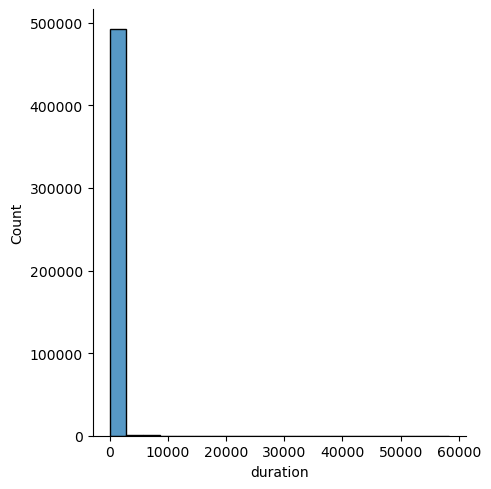

In [12]:

# Visualize the distribution of the 'duration' feature
sns.displot(training_df['duration'], kde=False)

### Pre Processing


In [ ]:
# Convert categorical features to numerical features
le = LabelEncoder()
categorical_columns = training_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    training_df[col] = le.fit_transform(training_df[col])

# Normalization
scaler = StandardScaler()
training_df_scaled = scaler.fit_transform(training_df)

#Visualization
training_df_scaled = pd.DataFrame(training_df_scaled, columns=training_df.columns)
sns.pairplot(training_df_scaled)

## Clustering Using K-Means and Normalized Cut

In [ ]:
# Apply K-Means clustering with different values of K
k_values = [7, 15, 23, 31, 45]
for k in k_values:
    labels_km = kmeans(training_df_scaled, k)
    silhouette_km = silhouette_score(training_df_scaled, labels_km)
    print("Silhouette Score for K-Means Clustering with K=%d: %f" % (k, silhouette_km))

    
# Apply Normalized Cuts clustering
labels_nc = normalized_cuts(training_df_scaled, 5)
silhouette_nc = silhouette_score(training_df_scaled, labels_nc)
print("Silhouette Score for Normalized Cuts Clustering: %f" % silhouette_nc)



## New Clustering Algorithm <Clustering Techinque>

In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df)
labels_db = dbscan.labels_
silhouette_db = silhouette_score(df, labels_db)
print("Silhouette Score for DBSCAN Clustering:", silhouette_db)